In [1]:
using carretera1D2

In [2]:
using PyPlot

INFO: Loading help data...


In [60]:

function Modelo_NaSch( R, s, T, Tf, N, Secciones, T2)

  #T = 12; Tf = 3600; N = 3000

  C = Carretera1D(N)
  #Secciones = [1:300:N]
  S = length(Secciones)
  A = fld(Tf, T)+1
  X = zeros(Tf, Tf+1)
  flujo_local = zeros(S, A)
  densidad_local = zeros(S, A)
  velocidad_local_promedio = zeros(S, A)
    
  A2 = fld(Tf, T2)+1
  flujo_local2 = zeros(S, A2)
  densidad_local2 = zeros(S, A2)
  velocidad_local_promedio2 = zeros(S, A2)

  for t = 0:Tf-1

    #if t > N
      Espacio_Tiempo!(X, C.carretera, t+1)
    #end

    Insertar_Carro!(C.carretera, 0., t+1)

    AcelerarRuido_NaSch(C.carretera, R)
    DesacelerarMover_NaSch(C, 1.0)

    #if t > N
            Medir_NaSch(C, div(t+1, T)+1, Secciones, T, flujo_local, densidad_local, velocidad_local_promedio)
            Medir_NaSch(C, div(t+1, T2)+1, Secciones, T2, flujo_local2, densidad_local2, velocidad_local_promedio2)
    #end
  end
    return densidad_local, flujo_local, flujo_local2, densidad_local2
    #PyPlot.plot(densidad_local(s,:), flujo_local(s, :))
    #PyPlot.plot(Tf, X)

end

Modelo_NaSch (generic function with 3 methods)

In [66]:
  T = 12; Tf = 1000; N = 3600; T2 = 100
  Secciones = [1:180:N]

densidad_local, flujo_local, flujo_local2, densidad_local2  = Modelo_NaSch(0.4, 2, T, Tf, N, Secciones, T2);

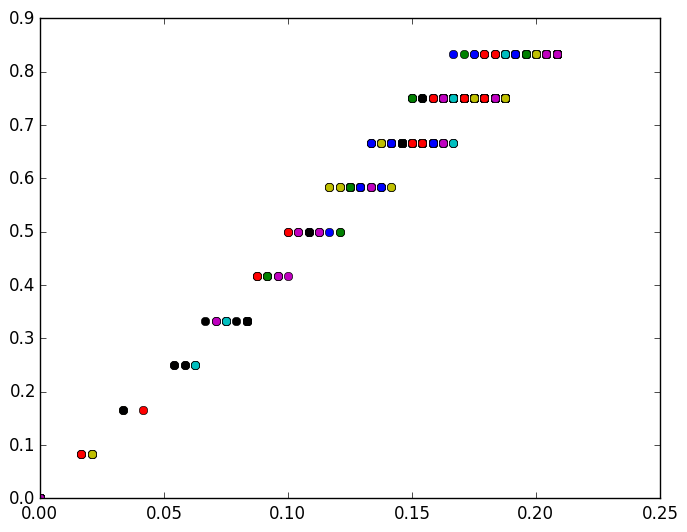

In [67]:
for s = 1:length([1:180:3600])
    PyPlot.plot(sub(densidad_local,s,:), sub(flujo_local,s, :), "o")
    PyPlot.plot(sub(densidad_local,s,:), sub(flujo_local,s, :), "-")
end


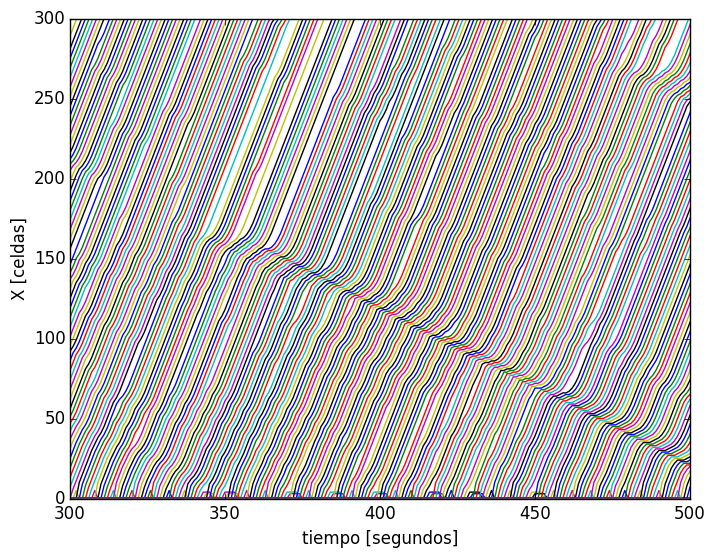

In [46]:
for v = 2:size(X)[1]
    PyPlot.plot([1:Tf], [x for x in X[v, 1:end-1]])
end
PyPlot.xlim(300,500)
PyPlot.ylim(0,300)
PyPlot.xlabel("tiempo [segundos]")
PyPlot.ylabel("X [celdas]")

PyPlot.savefig("Propagacion.png", format = "png", bbox_inches="tight")

In [50]:
########################### Funciones Autómatas Celulares ################################

function AcelerarRuido_NaSch(carretera, R::Float64, vmax::Array{Int8, 1} = Int8[3, 5], frontera_izq::Int64 = 5)

    for v in carretera[frontera_izq+1:end]
        if v.tipo == 1 || v.tipo == 2

            #Acelerar
            if v.velocidad != -1
                Cambiar_Vehiculo!(v, min(v.velocidad+1, vmax[v.tipo]), v.posicion, v.tipo, v.cambio, v.num)
            end

            #Ruido
            if v.velocidad > 0
                if rand() <= R
                    Cambiar_Vehiculo!(v, max(v.velocidad-1, 0), v.posicion, v.tipo, v.cambio, v.num)
                end
            end
        end
    end
end


function DesacelerarMover_NaSch(C, alfa::Float64, frontera_izq = 5)

    i = Pos_izq(C.carretera)
    i_1 = ( i > 1 ? Pos_izq(C.carretera[1:i-1]) : 0 )

    # Este while es para los pasos siguientes
    while (i > 0)

        if i_1 != 0
          distancia = i - i_1 - 1

          # Desaceleramos el automovil i-1 a partir del automovil i
          velocidad_estimada = floor( C.carretera[i].velocidad * (1.0 - alfa) + 0.5 )
          Cambiar_Vehiculo!(C.carretera[i_1], min( (velocidad_estimada+distancia), C.carretera[i_1].velocidad),
                              C.carretera[i_1].posicion, C.carretera[i_1].tipo, C.carretera[i_1].cambio, C.carretera[i_1].num)
        end
        
        # Movemos el automovil i

        pos_sig = C.carretera[i].velocidad + C.carretera[i].posicion
        if C.carretera[i].posicion != pos_sig #&& C.carretera[pos_sig].tipo == -1

            if pos_sig > C.N
                Celda_Vacia!(C.carretera[i])
                C.cuenta -= 1
            end
            
            if pos_sig <= C.N && C.carretera[pos_sig].tipo == -1
                
                if C.carretera[i].posicion <= frontera_izq && pos_sig > frontera_izq
                    C.cuenta += 1
                end
                
                Cambiar_Vehiculo!(C.carretera[pos_sig], C.carretera[i].velocidad, pos_sig, C.carretera[i].tipo, 0
                                    , C.carretera[i].num)

                Celda_Vacia!(C.carretera[i])
            elseif pos_sig <= C.N && C.carretera[pos_sig].tipo == -2
                while C.carretera[pos_sig].tipo == -2
                   pos_sig -= 1
                end
               Cambiar_Vehiculo!(C.carretera[pos_sig], C.carretera[i].velocidad, pos_sig, C.carretera[i].tipo, 0, 
                                C.carretera[i].num)
               Celda_Vacia!(C.carretera[i])
            end
        end
        # Reindexamos el automovil i-1 como el automovil i

        i = i_1
        i_1 = ( i > 1 ? Pos_izq(C.carretera[1:i-1]) : 0 )
    end
end

##################################### Auxiliares ###################################

function agregar_sencillo_NaSch!(array_velocidad, array_flujo, array_densidad, i, t, T)

    v = ( array_densidad[i, t] != 0 ? array_flujo[i, t]/array_densidad[i, t] : 0 )
    array_velocidad[i, t] += v/T
end

function agregar_NaSch!(i, j, t, x_seccion, v, array, T)

    if v.velocidad > 0
        if j-v.velocidad < x_seccion
            array[i, t] += 1/T
        end
    end
end

#################################### Mediciones ######################################

function Medir_NaSch(C, t, Secciones, T, flujo_local, densidad_local, velocidad_local_promedio)

    for (i, x_seccion) in enumerate(Secciones)

        # Medicion del flujo local
        for j = x_seccion+4:-1:x_seccion
            agregar_NaSch!(i, j, t, x_seccion, C.carretera[j], flujo_local, T)
        end

        # Medicion de la densidad local
        for j = x_seccion+4:-1:x_seccion
            agregar_NaSch!(i, j, t, x_seccion, C.carretera[j], densidad_local, T*C.carretera[j].velocidad)
        end

        # Medicion de la velocidad promedio espacial

        agregar_sencillo_NaSch!( velocidad_local_promedio, flujo_local, densidad_local, i, t, T )

    end
end

function Espacio_Tiempo!(X, carretera, t)

    for v in carretera
        if v.tipo == 1 || v.tipo == 2
            X[v.num, t] = v.posicion
        end
    end
end

Espacio_Tiempo! (generic function with 1 method)

In [15]:
f = int8(5)
v = Int8[3,5]
l = f +v[1]
typeof(l+int8(1)-v[2])

typeof(rand() <= 0.3 ? v[1] : v[2])

Int8

In [77]:
div(1001,20)+1

51

In [79]:
length([1:div(1001,20)+1:1001])

20

In [12]:
typeof(f), typeof(v)

(Int8,Array{Int8,1})

In [17]:
3===v[1]

false

In [3]:
function Insertar_CarroN!(carretera, num::Int64, p::Float64, vmax = [3, 5], frontera_izq = 5 )
    #frontera_izq = 5
    #vmax = [3, 5]

    lim = frontera_izq + 1
    while carretera[lim].tipo == -1 && lim < (frontera_izq+vmax[2])
        lim += 1
    end
    v_nueva = ( rand() <= p ? vmax[1] : vmax[2] )
    pos_nueva = min( lim - vmax[2], v_nueva)
    tipo = (v_nueva == vmax[1] ? 1 : 2 )
    Cambiar_Vehiculo!(carretera[pos_nueva], v_nueva, pos_nueva, tipo, 1, num)

#    lim = 0; v_nueva = 0; pos_nueva = 0; tipo = 0;
#    frontera_izq = 0; vmax = 0
end


Insertar_CarroN! (generic function with 3 methods)

Insertar_CarroN! (generic function with 3 methods)

In [36]:

  T = 12; Tf = 1500; N = 1000; R=0.2

  C = Carretera1D(N)
  Secciones = [1:500:N]
  S = length(Secciones)
  A = fld(Tf-N, T)+1
  X = zeros(Tf, Tf+1)
  flujo_local = zeros(S, A)
  densidad_local = zeros(S, A)
  velocidad_local_promedio = zeros(S, A)

  for t = 0:Tf-1

    if t > N
      Espacio_Tiempos!(X, C.carretera, t+1)
    end

    Insertar_Carro!(C.carretera, 0., t+1)

    AcelerarRuido_NaSch(C.carretera, R)
    DesacelerarMover_NaSch(C, 1.0)
end

LoadError: BoundsError()
while loading In[36], in expression starting on line 13

In [37]:
i = Pos_izq(C.carretera)

999

In [38]:
i_1 = ( i > 1 ? Pos_izq(C.carretera[1:i-1]) : 0 )

983

In [39]:
C.carretera[i].posicion+C.carretera[i].velocidad

1004

In [8]:
C.carretera[1:13]

13-element Array{Vehiculo,1}:
 Vehiculo(-1,1,-1,0,0) 
 Vehiculo(-1,2,-1,0,0) 
 Vehiculo(5,3,2,1,207) 
 Vehiculo(-1,4,-1,0,0) 
 Vehiculo(-1,5,-1,0,0) 
 Vehiculo(-1,6,-1,0,0) 
 Vehiculo(-1,7,-1,0,0) 
 Vehiculo(5,8,2,0,206) 
 Vehiculo(-1,9,-1,0,0) 
 Vehiculo(-1,10,-1,0,0)
 Vehiculo(-1,11,-1,0,0)
 Vehiculo(-1,12,-1,0,0)
 Vehiculo(5,13,2,0,205)

In [9]:
Pos_izq(C.carretera)

10

In [54]:
DesacelerarMover_NaSch(C, 1.0)

LoadError: BoundsError()
while loading In[54], in expression starting on line 1

LoadError: BoundsError()
while loading In[54], in expression starting on line 1

In [26]:
N = 30
C = Carretera1D(N);

In [32]:
C.carretera;

In [37]:
Insertar_Carro!(C.carretera, 0., 3)
C.carretera

30-element Array{Vehiculo,1}:
 Vehiculo(-1,1,-1,0,0) 
 Vehiculo(-1,2,-1,0,0) 
 Vehiculo(-1,3,-1,0,0) 
 Vehiculo(-1,4,-1,0,0) 
 Vehiculo(5,5,2,1,3)   
 Vehiculo(-1,6,-1,0,0) 
 Vehiculo(-1,7,-1,0,0) 
 Vehiculo(-1,8,-1,0,0) 
 Vehiculo(-1,9,-1,0,0) 
 Vehiculo(5,10,2,0,2)  
 Vehiculo(-1,11,-1,0,0)
 Vehiculo(-1,12,-1,0,0)
 Vehiculo(-1,13,-1,0,0)
 ⋮                     
 Vehiculo(-1,19,-1,0,0)
 Vehiculo(5,20,2,0,1)  
 Vehiculo(-1,21,-1,0,0)
 Vehiculo(-1,22,-1,0,0)
 Vehiculo(-1,23,-1,0,0)
 Vehiculo(-1,24,-1,0,0)
 Vehiculo(-1,25,-1,0,0)
 Vehiculo(-1,26,-1,0,0)
 Vehiculo(-1,27,-1,0,0)
 Vehiculo(-1,28,-1,0,0)
 Vehiculo(-1,29,-1,0,0)
 Vehiculo(-1,30,-1,0,0)

30-element Array{Vehiculo,1}:
 Vehiculo(-1,1,-1,0,0) 
 Vehiculo(-1,2,-1,0,0) 
 Vehiculo(-1,3,-1,0,0) 
 Vehiculo(-1,4,-1,0,0) 
 Vehiculo(5,5,2,1,3)   
 Vehiculo(-1,6,-1,0,0) 
 Vehiculo(-1,7,-1,0,0) 
 Vehiculo(-1,8,-1,0,0) 
 Vehiculo(-1,9,-1,0,0) 
 Vehiculo(5,10,2,0,2)  
 Vehiculo(-1,11,-1,0,0)
 Vehiculo(-1,12,-1,0,0)
 Vehiculo(-1,13,-1,0,0)
 ⋮                     
 Vehiculo(-1,19,-1,0,0)
 Vehiculo(5,20,2,0,1)  
 Vehiculo(-1,21,-1,0,0)
 Vehiculo(-1,22,-1,0,0)
 Vehiculo(-1,23,-1,0,0)
 Vehiculo(-1,24,-1,0,0)
 Vehiculo(-1,25,-1,0,0)
 Vehiculo(-1,26,-1,0,0)
 Vehiculo(-1,27,-1,0,0)
 Vehiculo(-1,28,-1,0,0)
 Vehiculo(-1,29,-1,0,0)
 Vehiculo(-1,30,-1,0,0)

In [38]:
AcelerarRuido_NaSch(C.carretera, 0.2)
C.carretera;

In [39]:
DesacelerarMover_NaSch(C, 1.)
C.carretera

30-element Array{Vehiculo,1}:
 Vehiculo(-1,1,-1,0,0) 
 Vehiculo(-1,2,-1,0,0) 
 Vehiculo(-1,3,-1,0,0) 
 Vehiculo(-1,4,-1,0,0) 
 Vehiculo(-1,5,-1,0,0) 
 Vehiculo(-1,6,-1,0,0) 
 Vehiculo(-1,7,-1,0,0) 
 Vehiculo(-1,8,-1,0,0) 
 Vehiculo(4,9,2,0,3)   
 Vehiculo(-1,10,-1,0,0)
 Vehiculo(-1,11,-1,0,0)
 Vehiculo(-1,12,-1,0,0)
 Vehiculo(-1,13,-1,0,0)
 ⋮                     
 Vehiculo(-1,19,-1,0,0)
 Vehiculo(-1,20,-1,0,0)
 Vehiculo(-1,21,-1,0,0)
 Vehiculo(-1,22,-1,0,0)
 Vehiculo(-1,23,-1,0,0)
 Vehiculo(-1,24,-1,0,0)
 Vehiculo(5,25,2,0,1)  
 Vehiculo(-1,26,-1,0,0)
 Vehiculo(-1,27,-1,0,0)
 Vehiculo(-1,28,-1,0,0)
 Vehiculo(-1,29,-1,0,0)
 Vehiculo(-1,30,-1,0,0)

30-element Array{Vehiculo,1}:
 Vehiculo(-1,1,-1,0,0) 
 Vehiculo(-1,2,-1,0,0) 
 Vehiculo(-1,3,-1,0,0) 
 Vehiculo(-1,4,-1,0,0) 
 Vehiculo(-1,5,-1,0,0) 
 Vehiculo(-1,6,-1,0,0) 
 Vehiculo(-1,7,-1,0,0) 
 Vehiculo(-1,8,-1,0,0) 
 Vehiculo(4,9,2,0,3)   
 Vehiculo(-1,10,-1,0,0)
 Vehiculo(-1,11,-1,0,0)
 Vehiculo(-1,12,-1,0,0)
 Vehiculo(-1,13,-1,0,0)
 ⋮                     
 Vehiculo(-1,19,-1,0,0)
 Vehiculo(-1,20,-1,0,0)
 Vehiculo(-1,21,-1,0,0)
 Vehiculo(-1,22,-1,0,0)
 Vehiculo(-1,23,-1,0,0)
 Vehiculo(-1,24,-1,0,0)
 Vehiculo(5,25,2,0,1)  
 Vehiculo(-1,26,-1,0,0)
 Vehiculo(-1,27,-1,0,0)
 Vehiculo(-1,28,-1,0,0)
 Vehiculo(-1,29,-1,0,0)
 Vehiculo(-1,30,-1,0,0)